# **Wildfire Risk Prediction – Boulder, CO**  

This project demonstrates a machine learning workflow for predicting wildfire occurrence in the Boulder/Front Range region.  
The model integrates multiple environmental datasets, including **weather (NOAA)**, **fire history (NASA FIRMS)**, **vegetation indices (NDVI/EVI)**, and **drought stress (DSCI)**.  

The modeling approach utilizes **XGBoost** with evaluation metrics such as **ROC-AUC** and **F1 score** to assess predictive performance.  


In [87]:
# Core data and utilities
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import requests
from io import StringIO
from google.colab import userdata

# Machine learning
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score, classification_report

---
## **Load Datasets**

To model wildfire occurrence in the Boulder / Front Range region, I integrate multiple open datasets that capture both fire activity and its environmental drivers:

- **Fire Archive (NASA FIRMS)** - Satellite-detected fire events (ignitions + spread).
- **Weather (NOAA)** - Daily temperature, precipitation, wind speed, and related variables.
- **Vegetation Indices (NASA AppEEARS & MODIS)** - NDVI and EVI for vegetation health and fuel conditions.
- **Drought Index (US Drought Monitor)** - Weekly Drought Severity & Coverage Index (DSCI).

--

### NOAA Weather Data (via API)

Daily weather observations are retrieved directly from the NOAA Climate Data API:

- **API setup**: Token + endpoint  
- **Parameters**: Station ID, time range (2012–2025), output format (`csv`)  
- **Response**: Parsed into a `pandas` DataFrame (`noaa_data_raw`) for downstream modeling.


In [91]:
# Retrieve NOAA API key stored in Google Colab
token = userdata.get('NOAA_API')

# NOAA API token + endpoint
token = token
url = "https://www.ncei.noaa.gov/access/services/data/v1"

# Request parameters: dataset, station, time range, output format
params = {
    "dataset": "daily-summaries",
    "stations": "USW00003017",
    "startDate": "2012-01-01",
    "endDate": "2025-07-01",
    "format": "csv",
    "units": "standard",
    "includeAttributes": "false"
}

headers = {
    "token": token
}

# Send request and parse response into DataFrame
response = requests.get(url, params=params, headers=headers)
noaa_data_raw = pd.read_csv(StringIO(response.text))


# Load additional data needed for fire risk modeling
fire_data_raw = pd.read_csv("fire_archive_SV-C2_641212.csv") # NASA FIRMS
drought_data_raw = pd.read_csv("Drought_Index.csv") # US Drought Monitor
evi_data_raw = pd.read_csv('EVI.csv') # MODIS
ndvi_data_raw = pd.read_csv("NDVI.csv") # NASA AppEEARS

---
## **Clean Data**

Data preprocessing ensures consistency across datasets before merging.

- **NOAA Weather Data**: Remove rows with missing temperature values and reformatt dates.  
- **Wildfire Occurrence Data**: Aggregate fire counts by day, fill missing days with zero fires.  
- **Drought Data (DSCI)**: Reformatt dates and drop metadata columns.
- **NDVI Data**: Select relevant columns, rename them for clairty, and reformatt dates.
- **EVI Data**: Rename columns for consistency, converte the date column to datetime, and select relevant variables for analysis.




### NOAA Weather Data

In [92]:
# TAVG (average temperature) values are missing for early dates in the dataset; these rows are excluded
# Drop rows where TAVG is missing
noaa_data_clean = noaa_data_raw.dropna(subset='TAVG')

# Select relevant weather columns
# Convert date to datetime format
weather_data = noaa_data_clean[['TAVG', 'DATE', 'PRCP', 'AWND', 'WSF2', 'WSF5']].copy()
weather_data['DATE'] = pd.to_datetime(weather_data['DATE'])

### Wildfire Occurance Data

In [93]:
# Convert acquisition dates to datetime format
fire_data_raw['date'] = pd.to_datetime(fire_data_raw['acq_date'])

# Create a fire summary DataFrame with only the date column
# (for aggregating/removing duplicate fire records)
fire_summary = pd.DataFrame({'DATE': fire_data_raw['date']})

# Create a DataFrame with unique dates and 'num_fires' column
fire_count = fire_summary.groupby('DATE').size().rename('num_fires').reset_index()

# Create a DataFrame of dates ranging from the earliest fire occurance to the latest
full_dates = pd.DataFrame({
    'DATE': pd.date_range(start=fire_summary['DATE'].min(), end = fire_summary['DATE'].max())
})

# Merge full date range with fire counts
# Ensures all days are included in the data, including days with 0 fires
fire_data = full_dates.merge(fire_count, how='left', on = 'DATE')

# Fill all NaN values with 0's for days without fires
fire_data['num_fires'] = fire_data['num_fires'].fillna(0).astype(int)

### Drought Data (DSCI)

In [94]:
# Create date column in datetime format
drought_data_raw['DATE'] = pd.to_datetime(drought_data_raw['MapDate'], format = '%Y%m%d')

# Drop irrelevant columns
drought_data_filtered = drought_data_raw.drop(columns=
 ['Name', 'ClimateDivision', 'State', 'MapDate'],
 axis = 1)

### NDVI Data

In [95]:
# Select NDVI-related columns and rename them for clarity and consistency
ndvi_data_filtered = ndvi_data_raw[['Mean', 'Variance', 'Date']].copy()
ndvi_data_filtered.rename(columns = {'Mean': 'NDVI_Mean',
                       'Variance': 'NDVI_Variance',
                       'Date': 'DATE'
                       }, inplace = True)

# Change 'DATE' column to datetime format
ndvi_data_filtered['DATE'] = pd.to_datetime(ndvi_data_filtered['DATE'])

### EVI Data

In [96]:
# Rename columns for consistency
evi_data_raw.rename(columns={' dt': 'DATE',
                             ' value_min': 'evi_min',
                             ' value_max': 'evi_max',
                             ' value_mean': 'evi_mean',
                             ' value_standard_deviation': 'evi_standard_deviation',
                             }, inplace = True)

# Covert 'DATE' column to datetime format
evi_data_raw['DATE'] = pd.to_datetime(evi_data_raw['DATE'])

# Select relevant EVI columns for analysis
evi_data_filtered = evi_data_raw[['DATE', 'evi_min', 'evi_max', 'evi_mean', 'evi_standard_deviation']].copy()

---
## **Merge Data**

All preprocessed datasets are merged into a single DataFrame (`full_df`) on the `DATE` column.  

Steps:  
1. Merge weather, fire, drought, NDVI, and EVI data.  
2. Align datasets by overlapping date range to ensure consistency across sources.  
3. Filter `full_df` so all rows represent dates present in every dataset.  

The resulting DataFrame provides a unified, time-aligned dataset for modeling.  


In [97]:
# Merge all datasets into 'full_df'
df_temp = pd.merge(weather_data, fire_data, how='inner', on='DATE')
df_temp_1 = pd.merge(df_temp, drought_data_filtered, how = 'left', on = 'DATE')
df_temp_2 = pd.merge(df_temp_1, ndvi_data_filtered, how = 'left', on = 'DATE')
full_df = pd.merge(df_temp_2, evi_data_filtered, how = 'left', on = 'DATE')

# List of relevant DataFrames to align by date
dfs = [weather_data, fire_data, drought_data_filtered, ndvi_data_filtered, evi_data_filtered]

# Determine overlapping date range across all DataFrames
latest_start = max(df['DATE'].min() for df in dfs)
earliest_end = min(df['DATE'].max() for df in dfs)

# Filter full_df to only include rows within the date range
# Confirms all datasets have matching dates
full_df = full_df.loc[(full_df['DATE'] >= latest_start) & (full_df['DATE'] <= earliest_end)]

---
## **Initial Data Analysis (IDA)**
Initial Data Analysis (IDA) is performed to assess data quality, focusing on handling missing values, and validating feature ranges.

### Data Types
Look for potential object columns that have numerical values stored as strings.

In [98]:
# Check the data type of each column
print(full_df.dtypes)

TAVG                             float64
DATE                      datetime64[ns]
PRCP                             float64
AWND                             float64
WSF2                             float64
WSF5                             float64
num_fires                          int64
DSCI                             float64
NDVI_Mean                        float64
NDVI_Variance                    float64
evi_min                          float64
evi_max                          float64
evi_mean                         float64
evi_standard_deviation           float64
dtype: object


All features are numeric with no object-type columns detected. Therefore, no data type conversions are required.

### Value Ranges
- Vegetation indices should be between -1 and 1
- Precipitation must be ≥ 0
- Temperature should have realistic bounds for Colorado (-15°F to 115°F)
- Wind speed must be ≥ 0

In [99]:
# Weather checks
invalid_temp = ((full_df['TAVG'] < -15) | (full_df['TAVG'] > 115)).any()
print(f'TAVG: {invalid_temp}')

invalid_prcp = (full_df['PRCP'] < 0).any()
print(f'PRCP: {invalid_prcp}')

invalid_DSCI = ((full_df['DSCI'] < 0) | (full_df['DSCI'] > 500)).any()
print(f'DSCI: {invalid_DSCI}')

# Wind checks
wind_cols = ['AWND', 'WSF2', 'WSF5']
for c in wind_cols:
  has_invalid = ((full_df['AWND'] < 0) | (full_df['AWND'] > 60)).any()
  print(f'{c}: {has_invalid}')

# Vegetation checks
veg_cols = ['NDVI_Mean', 'NDVI_Variance', 'evi_min', 'evi_max', 'evi_mean', 'evi_standard_deviation']
for c in veg_cols:
    has_invalid = ((full_df[c] < -1) | (full_df[c] > 1)).any()
    print(f'{c}: {has_invalid}')

TAVG: False
PRCP: False
DSCI: False
AWND: False
WSF2: False
WSF5: False
NDVI_Mean: False
NDVI_Variance: False
evi_min: False
evi_max: False
evi_mean: False
evi_standard_deviation: False


All features are within expected ranges.

### Missing Values

In [100]:
# Count missing values per column
missing_counts = full_df.isna().sum()

# Create a report
missing_report = pd.DataFrame({
    "Missing Count": missing_counts
})

print(missing_report)

                        Missing Count
TAVG                                0
DATE                                0
PRCP                                0
AWND                                1
WSF2                                1
WSF5                                5
num_fires                           0
DSCI                             3366
NDVI_Mean                        3681
NDVI_Variance                    3681
evi_min                          3681
evi_max                          3681
evi_mean                         3681
evi_standard_deviation           3681


Aside from the 7 and 16-day intervals left by drought and vegetation indices, the wind variables (AWND, WSF5, WSF2) contain missing values. These are imputed by forward filling, on the assumption short gaps in the dataset can be reasonably approximated by carrying forward the most recent observed value. Drought and vegetation indices are addressed in the feature engineering section.



In [101]:
# Forward filling mssing values in wind variables
full_df[['AWND', 'WSF2', 'WSF5']] = full_df[['AWND', 'WSF2', 'WSF5']].ffill()

### Outlier Detection
Check for outliers for key columns.

In [102]:
key_features = ['num_fires', 'TAVG', 'PRCP', 'AWND', 'NDVI_Mean', 'DSCI', 'evi_mean']
print(full_df[key_features].agg(['min', 'mean', 'max']))

      num_fires       TAVG      PRCP       AWND  NDVI_Mean        DSCI  \
min    0.000000 -11.000000  0.000000   3.580000   0.066327    0.000000   
mean   0.326884  52.145876  0.037905   9.962368   0.410193   85.453737   
max   80.000000  86.000000  2.920000  32.880000   0.637805  360.000000   

      evi_mean  
min  -0.004600  
mean  0.240689  
max   0.436300  


The `num_fires` feature stands out with a max of 80 fires. Although this seem like an outlier, high `num_fires` values are produced by satellites either representing numerous small ignitions or multiple satellite detections of the same wildfire across different pixels. These counts are retained as-is to represent fire condition intensity rather than an actual fire count.

---
## **Exploratory Data Analysis (EDA)**
The goal of this section is to explore the data, including an overview of target imbalance, the distribution of key features, their relationship with fire occurrence, and seasonal trends in wildfire activity.


### Target Distribution


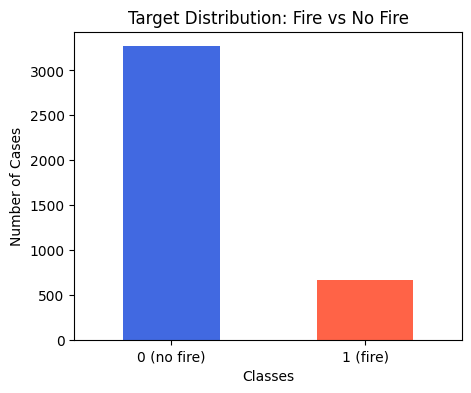

In [103]:
# Create binary target variable: 0 = no fire, 1 = fire
fire_flag = (full_df['num_fires'] > 0).astype(int)

# Count how many cases belong to each class (0 vs 1)
class_counts = fire_flag.value_counts().sort_index()

# Plot
plt.figure(figsize=(5,4))
class_counts.plot(kind='bar', color=['royalblue', 'tomato'])
plt.xticks([0,1], ['0 (no fire)', '1 (fire)'], rotation=0)
plt.ylabel("Number of Cases")
plt.xlabel("Classes")
plt.title("Target Distribution: Fire vs No Fire")
plt.show()

**Target Distribution:** The data is highly imbalanced, with ~80% of the data being in Class 0. Parameters like `scale_pos_weight` in XGBoost and target engineering are used to reduce imbalance.

### Wildfire Seasonality

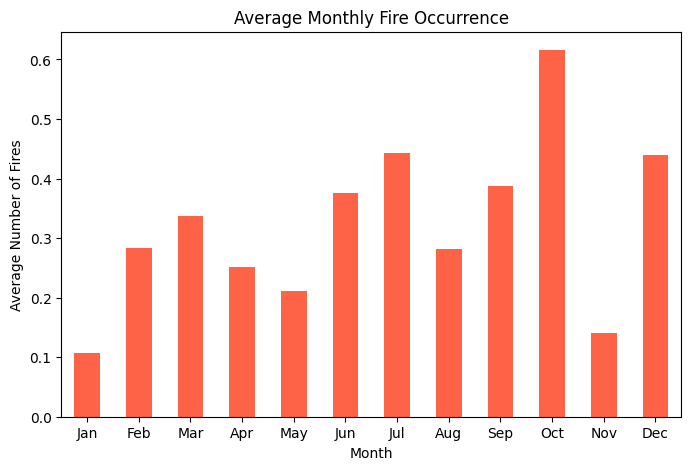

In [104]:
# Extract month
full_df['month'] = full_df['DATE'].dt.month
full_df['year'] = full_df['DATE'].dt.year

# Aggregate: average fires per month across all years
monthly_avg = full_df.groupby('month')['num_fires'].mean()

# Plot
plt.figure(figsize=(8,5))
monthly_avg.plot(kind='bar', color='tomato')
plt.xticks(range(0,12), ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'], rotation=0)
plt.ylabel("Average Number of Fires")
plt.xlabel("Month")
plt.title("Average Monthly Fire Occurrence")
plt.show()

**Average Monthly Fire Occurance:** Fires generally peak in the summer months, but a few outlier months (October and December) had unusually high fire counts in certain years (see `top5_fires` below). Some fires also occur in February and March, which is consistent with occasional early-season events in Colorado. To capture seasonality, cyclical month features are created using sine and cosine transformations.

In [105]:
full_df['month'] = full_df['DATE'].dt.month

# Aggregate total fires per month-year
fires_by_month = full_df.groupby(['year','month'])['num_fires'].sum().reset_index()

# Sort by number of fires descending and show top 5
top5_fires = fires_by_month.sort_values(by='num_fires', ascending=False).head(5)
top5_fires

,year,month,num_fires
78,2020,10,139
92,2021,12,112
28,2016,7,52
39,2017,6,43
101,2022,9,32


### Feature Correlation

#### TAVG by Fire Occurrence

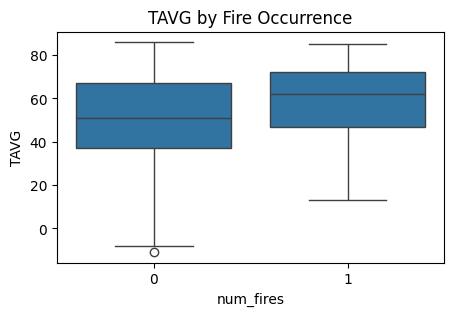

In [106]:
plt.figure(figsize=(5,3))
sns.boxplot(x=fire_flag, y=full_df['TAVG'])
plt.title('TAVG by Fire Occurrence')
plt.show()

**TAVG by Fire Occurrence:** Fire days generally occur at higher temperatures, as indicated by the higher median TAVG. The interquartile range is narrower on fire days, suggesting that extreme temperature values are less variable when fires occur.

#### Average NDVI by Fire Occurrence

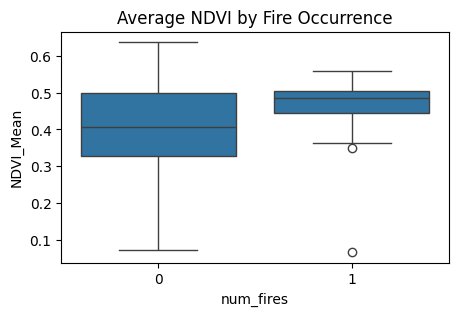

In [107]:
plt.figure(figsize=(5,3))
sns.boxplot(x=fire_flag, y=full_df['NDVI_Mean'])
plt.title('Average NDVI by Fire Occurrence')
plt.show()

**Average NDVI by Fire Occurrence:** NDVI values indicate denser, healthier vegetation, providing more fuel for wildfires. During the fire season, areas with high NDVI combined with dry conditions and warm temperatures may have elevated fire risk.

#### DSCI by Fire Occurrence

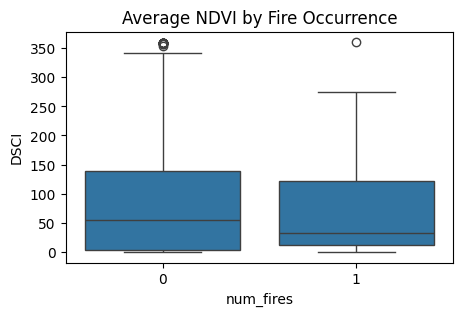

In [108]:
plt.figure(figsize=(5,3))
sns.boxplot(x=fire_flag, y=full_df['DSCI'])
plt.title('Average NDVI by Fire Occurrence')
plt.show()

**DSCI by Fire Occurrence:** Interestingly, fire days in this dataset tend to have lower DSCI values, despite higher values indicating more drought. This may reflect that fires require both dry conditions and sufficient vegetation to act as fuel, so extremely high drought regions may have less combustible material, while moderately dry areas are more fire-prone.

---
## **Feature Engineering**

This section creates derived features to capture temporal trends, anomalies, and seasonality in wildfire drivers.  


### Rolling Features
Capture short-term weather and fire dynamics using rolling means and sums.




In [109]:
# 7-day average of temperature
full_df['TAVG_week_avg'] = full_df['TAVG'].rolling(window=7).mean().shift(1)

# Sum of fires in the past week
full_df['num_fires_pastweek'] = full_df['num_fires'].rolling(window=7).sum().shift(1)

# 3-day rolling average of the interaction bewteen average temperature and average wind
full_df['TAVGxAWND'] = (full_df['TAVG'] * full_df['AWND']).rolling(window=3).mean().shift(1)

# 7-day and 30-day rolling sum of precipitation
# Both 7-day and 30-day features were included to capture short term and long term patterns
full_df['PRCP_7_sum'] = full_df['PRCP'].rolling(window=7).sum()
full_df['PRCP_30_sum'] = full_df['PRCP'].rolling(window=7).sum()

### Anomaly Features
Highlight unusual weather conditions by comparing daily values to historical averages.


In [110]:
# Extract day of year from 'DATE' to find historical precipitation means
full_df['doy'] = full_df['DATE'].dt.day

# Find historical precipitation means and map them to their respective 'doy'
climatology_7 = full_df.groupby('doy')['PRCP_7_sum'].mean()
climatology_30 = full_df.groupby('doy')['PRCP_30_sum'].mean()

# Compute precipitation anomalies by subtracting climatological means
full_df['anom_PRCP_7'] = full_df['PRCP_7_sum'] - full_df['doy'].map(climatology_7)
full_df['anom_PRCP_30'] = full_df['PRCP_30_sum'] - full_df['doy'].map(climatology_30)

### Interval Features
Impute missing data created by satellite data collection (7/16 day intervals).

In [111]:
interval_features = ['evi_min', 'evi_max', 'evi_mean', 'evi_standard_deviation',
            'NDVI_Mean', 'NDVI_Variance', 'DSCI']

# Forward fill missing values for interval data (carry last known observation until the next update)
# Lag by 1 to prevent data leakage
full_df[interval_features] = full_df[interval_features].ffill().shift(1)

# Impute the first 7 rows of DSCI data with the intital DSCI value
# (the first drought value on 2013-12-31 was cutoff by the date range of 'full_df')
first_drought = drought_data_filtered['DSCI'].iloc[0]
full_df.loc[:7, 'DSCI'] = first_drought

### Lagged Wind Features
Prevent data leakage by lagging wind variables.

In [112]:
# Maximum wind speed in any 5-second period, lagged to prevent leakage
full_df['WSF5_SHIFT'] = full_df['WSF5'].shift(1)

# Average wind on a given day, lagged to prevent leakage
full_df['AWND_SHIFT'] = full_df['AWND'].shift(1)

### Temporal Features
Encode time-based features to capture seasonality.

In [113]:
# Extract the month of each date
full_df['month'] = full_df['DATE'].dt.month

# Cyclical encoding of the month variable using sine and cosine transformations
# This preserves seasonality by mapping months on the unit circle
# (e.g., December is close to January even though 12>>1)
full_df['feature_sine'] = np.sin(2* np.pi * (full_df['month']/12))
full_df['feature_cos'] = np.cos(2* np.pi * (full_df['month']/12))

### Dataset Cleaning:
Remove intermediate columns and missing values created by the rolling features.

In [114]:
# Drop first 7 rows with NaNs from rolling features
full_df = full_df.drop(full_df.index[:7])

# Remove Raw inputs columns
full_df = full_df.drop(['PRCP', 'AWND', 'WSF2', 'TAVG', 'WSF5'], axis = 1)

---
## **Model Setup**
Define the machine learning model, training parameters, and evaluation strategy used for wildfire prediction.

This section presents the baseline and intermediate models, highlighting how class imbalance is addressed through target engineering.

### **Baseline Model**
Uses engineered features without target adjustments for class imbalance.

#### Define Model Input (features) and Output (target) Variables
`X` contains all engineered predictor variables.

`y` is a binary target indicating fire occurance on a given day.



In [115]:
# Define the target variable
# Binary indicator of whether or not there is a fire on a given day
full_df['is_fire'] = (full_df['num_fires'] > 0).astype(int)

# Define features
features = ['TAVG_week_avg',
            'AWND_SHIFT', 'num_fires_pastweek',
             'TAVGxAWND', 'WSF5_SHIFT',
            'feature_sine', 'feature_cos',
            'evi_min', 'evi_max', 'evi_mean',  'evi_standard_deviation',
            'DSCI', 'PRCP_7_sum', 'PRCP_30_sum', 'anom_PRCP_7', 'anom_PRCP_30',
            'NDVI_Mean', 'NDVI_Variance'
            ]

X = full_df[features]
y = full_df['is_fire']

#### Split Data Using 'train_test_split' to Create Training and Validation Data
`test_size` is set to 0.2 to have 80% of the original data as training data.

`shuffle` is set to `False` to preserve the temporal aspect of the data.

In [116]:
X_train, X_val, y_train, y_val = train_test_split(X,y, test_size =0.2, shuffle = False)

#### Calculate `scale_pos_weight` for Imbalanced Data.

In [117]:
neg = np.sum(y_train == 0)
pos = np.sum(y_train == 1)

scale_pos_weight = neg/pos

#### Define XGBoost Model
Using `XGBClassifier` model with parameters chosen to balance learning stability and generalization.

In [118]:
base_model = XGBClassifier(
    n_estimators = 500,                # number of trees
    learning_rate = 0.05,              # step size shrinkage to prevent overfitting
    early_stopping_rounds = 20,        # stop if eval metric doesn't improve
    eval_metric = 'auc',               # metric for early stopping
    scale_pos_weight=scale_pos_weight, # balances the positive and negative classes; helps handle imbalance
    max_depth = 5,                     # deeper trees capture complex patterns but risk overfitting
    subsample = 0.3,                   # small fraction to reduce overfitting and improve generalization
    random_state = 42,                 # ensures reproducibility
    )

#### Train Model

In [ ]:
base_model.fit(X_train,
             y_train,
             eval_set = [(X_val, y_val)], # Used for auc evaluation for early stopping
             verbose = False
             )

#### Classification Report

In [120]:
y_base_preds = base_model.predict(X_val)
print(classification_report(y_val, y_base_preds))

              precision    recall  f1-score   support

           0       0.87      0.84      0.85       644
           1       0.38      0.45      0.41       141

    accuracy                           0.77       785
   macro avg       0.62      0.64      0.63       785
weighted avg       0.78      0.77      0.77       785



The baseline model achieves relatively high overall accuracy (0.77), but the minority class (fires) has low F1 (0.41). This indicates that the model mostly predicts the majority class (no fire), so accuracy is misleadingly high due to class imbalance.

### **Intermediate Model**
The intermediate model builds on the base model by using an engineered target to handle class imbalance. All inputs and model parameters were kept the same.

#### Target Creation
Define the wildfire occurance target variable. A binary indicator of whether a fire occurs in the next 7 days.

In [121]:
# Contructed by shifting 'num_fires' backwards to align with future events,
# then applying a rolling sum and converting to 1 (fire) or 0 (no fire)
full_df['fire_future_week'] = (
    full_df['num_fires'].shift(-6)
   .rolling(window=7, min_periods=1)
   .sum() > 0).astype(int)

#### Define Model Input and Output Variables

In [122]:
features = ['TAVG_week_avg',
            'AWND_SHIFT', 'num_fires_pastweek',
             'TAVGxAWND', 'WSF5_SHIFT',
            'feature_sine', 'feature_cos',
            'evi_min', 'evi_max', 'evi_mean',  'evi_standard_deviation',
            'DSCI', 'PRCP_7_sum', 'PRCP_30_sum', 'anom_PRCP_7', 'anom_PRCP_30',
            'NDVI_Mean', 'NDVI_Variance'
            ]

X = full_df[features]
y = full_df['fire_future_week']

#### Define and Fit Model

In [ ]:
# Split Data
X_train, X_val, y_train, y_val = train_test_split(X,y, test_size =0.2, shuffle = False)

# Calculate scale_pos_weight parameter
neg = np.sum(y_train == 0)
pos = np.sum(y_train == 1)
scale_pos_weight = neg/pos

# Define model
intermediate_model = XGBClassifier(
    n_estimators = 500,
    learning_rate = 0.05,
    early_stopping_rounds = 20,
    eval_metric = 'auc',
    scale_pos_weight=scale_pos_weight,
    max_depth = 5,
    subsample = 0.3,
    random_state = 42,
    )

# Fit model
intermediate_model.fit(X_train,
             y_train,
             eval_set = [(X_val, y_val)],
             verbose = False
             )

#### Classification Report

In [124]:
y_int_preds = intermediate_model.predict(X_val)
print(classification_report(y_val, y_int_preds))

              precision    recall  f1-score   support

           0       0.62      0.70      0.66       317
           1       0.78      0.71      0.74       468

    accuracy                           0.71       785
   macro avg       0.70      0.71      0.70       785
weighted avg       0.71      0.71      0.71       785



After target engineering, performance for the majority class (previously minority class) improves substantially (0.41 -> 0.74), with more balanced precision and recall across classes. Overall accuracy decreases slightly (0.77 -> 0.71) because the model now better represents rare fire events.

Class distribution also improves significantly after target engineering, going from a 20/80% class split to a 60/40% class split.

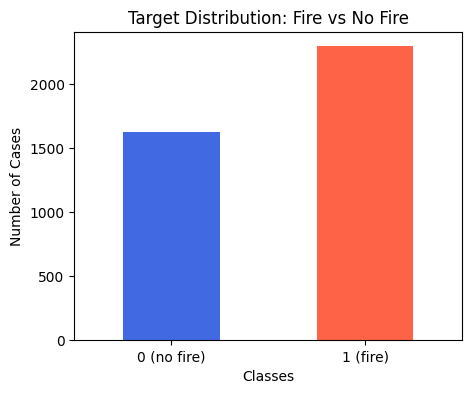

In [126]:
class_counts = full_df['fire_future_week'].value_counts().sort_index()

# Plot
plt.figure(figsize=(5,4))
class_counts.plot(kind='bar', color=['royalblue', 'tomato'])
plt.xticks([0,1], ['0 (no fire)', '1 (fire)'], rotation=0)
plt.ylabel("Number of Cases")
plt.xlabel("Classes")
plt.title("Target Distribution: Fire vs No Fire")
plt.show()

---
## **Model Evaluation**
This section evaluates model performance beyond initial training by tuning decision thresholds, checking for overfitting, and comparing models.

### **Decision Threshold Tuning**
To optimize performance on both classes, I tune the classification threshold from the default value of 0.5. Threshold tuning is done with the `average = weighted` parameter to account for both minority and majority class F1 scores.

#### Model Prediction

- Predict probabilities for the postive class (fire).
- `predict_proba` returns probabilities between 0 and 1.
- These will be used to optimize the model threshold.


In [127]:
pred_probs = intermediate_model.predict_proba(X_val)[:, 1]

#### Define Threshold Range and Prepare to Track F1 Scores
- Create a range of thresholds to test.
- Create an empty list to store f1 scores.


**Note**

Orginally, I tested thresholds from 0 to 1 in steps of 0.01. For a more precise estimate of the best threshold, I narrowed the range to 0.45-0.50 in steps of 0.001.

In [128]:
thresholds = np.arange(0.45, 0.51, 0.001)
f1_scores = []

#### Loop Over Thresholds to Compute F1 Scores
- For each threshold, convert probabilities into binary values and calculate the weighted average F1 score on validation data.


The weighted F1 score takes into account both the postive and negative class F1 scores, instead of just the positive class.
This allows me to optimize the model's ability to predict both classes.

In [129]:
for threshold in thresholds:
  y_preds = (pred_probs >= threshold).astype(int)
  score = f1_score(y_val, y_preds, average='macro')
  f1_scores.append(score)

#### Find Best Threshold
Identify which threshold yieled the highest weighted F1 score.

In [130]:
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
print(f'Best Threshold: {best_threshold}')

Best Threshold: 0.48900000000000005


#### Evaluate Final Predictions
Use the best threshold to convert probabilities into binary predictions and evaluate the classification metrics.

In [131]:
y_tuned_preds = (pred_probs >= best_threshold).astype(int)
print(classification_report(y_val, y_tuned_preds))

              precision    recall  f1-score   support

           0       0.65      0.65      0.65       317
           1       0.76      0.76      0.76       468

    accuracy                           0.72       785
   macro avg       0.70      0.70      0.70       785
weighted avg       0.72      0.72      0.72       785



Although there were minimal changes in F1 scores for both classes, threshold tuning improved the balance between precision and recall, decreasing the amount of false negatives in the positive class. This is especially important in wildfire forecasting, as false negatives are significantly more costly than false positives.

### **Overfitting Check**
I compare training and validation performance to assess generalization.

In [132]:
# Get predictions and classification report for training data based on the best threshold
y_train_pred = (intermediate_model.predict_proba(X_train)[:, 1] >= best_threshold).astype(int)
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       0.68      0.74      0.71      1309
           1       0.80      0.75      0.77      1827

    accuracy                           0.75      3136
   macro avg       0.74      0.75      0.74      3136
weighted avg       0.75      0.75      0.75      3136



The difference in F1 scores was small (~0.06 for the minority class and ~0.01 for the majority class), suggesting minimal overfitting. This indicates that the model generalizes to unseen data fairly well.

### **Model Comparison Visual**
I compare precision, recall, and F1 scores across both positive and negative classes for the baseline, intermediate, and threshold-tuned models, visualized in a heatmap to highlight performance differences.



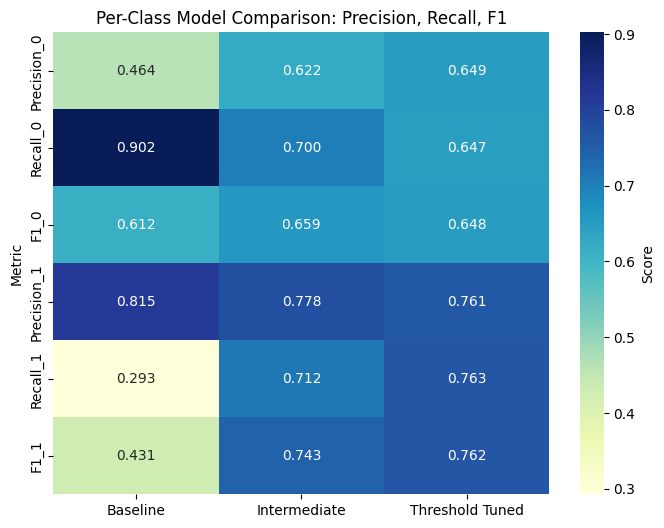

In [133]:
# Get metrics in dictionary form
baseline_report = classification_report(y_val, y_base_preds, output_dict=True)
intermediate_report = classification_report(y_val, y_int_preds, output_dict=True)
tuned_report = classification_report(y_val, y_tuned_preds, output_dict=True)

# Extract per-class metrics
def extract_per_class(report, classes=['0','1']):
    metrics = {}
    for cls in classes:
        metrics[f'Precision_{cls}'] = report[cls]['precision']
        metrics[f'Recall_{cls}'] = report[cls]['recall']
        metrics[f'F1_{cls}'] = report[cls]['f1-score']
    return metrics

# Create a DataFrame with metrics as rows and models as columns
data = pd.DataFrame({
    'Baseline': extract_per_class(baseline_report),
    'Intermediate': extract_per_class(intermediate_report),
    'Threshold Tuned': extract_per_class(tuned_report)
})

# Plot heatmap
plt.figure(figsize=(8,6))
sns.heatmap(data, annot=True, fmt=".3f", cmap="YlGnBu", cbar_kws={'label':'Score'})
plt.title("Per-Class Model Comparison: Precision, Recall, F1")
plt.ylabel("Metric")
plt.show()

Baseline scores show inflated Recall_0 and Precision_1 due to the imbalanced target data, where the model over-predicted the negative class. This resulted in a low F1 score for the positive class (fire). The intermediate model, with an engineered target, reduced imbalance and substantially improved metrics across both classes. Threshold tuning then traded a small drop in negative-class performance for a meaningful gain in positive-class recall, reducing false negatives, a critical factor to consider in wildfire forecasting.